In [1]:
import pandas as pd
pd.__version__

'1.1.0'

### Data Loading

Load all the data from the input files into a single data frame:

In [2]:
dfList = []
for i in range(1, 32):
    one_day_df = pd.read_json("./data/return-data/2017-01-{0:02d}.txt".format(i), lines=True)
    dfList.append(one_day_df)
df = pd.concat(dfList).reset_index(drop=True)

Let's check the distribution of the class label and have a look at the data:

In [3]:
print(df.returnLabel.value_counts())
df.head()

0    30065
1      935
Name: returnLabel, dtype: int64


,transactionId,basket,zipCode,totalAmount,returnLabel
0,2558829880,"[1, 3, 0, 4, 1]",4768,295,0
1,4312367728,"[5, 0, 2, 5]",2025,172,0
2,9477966002,[4],6748,109,0
3,7208385291,[1],9880,27,0
4,7858059423,"[0, 5, 4, 0, 0, 2, 5]",8667,245,0


### Feature Engineering

We transform the basket into an vector which has the count of the individual categories as values

In [4]:
df['c_0'] = df.basket.map(lambda x: x.count(0))
df['c_1'] = df.basket.map(lambda x: x.count(1))
df['c_2'] = df.basket.map(lambda x: x.count(2))
df['c_3'] = df.basket.map(lambda x: x.count(3))
df['c_4'] = df.basket.map(lambda x: x.count(4))
df['c_5'] = df.basket.map(lambda x: x.count(5))

In [5]:
df.head()

,transactionId,basket,zipCode,totalAmount,returnLabel,c_0,c_1,c_2,c_3,c_4,c_5
0,2558829880,"[1, 3, 0, 4, 1]",4768,295,0,1,2,0,1,1,0
1,4312367728,"[5, 0, 2, 5]",2025,172,0,1,0,1,0,0,2
2,9477966002,[4],6748,109,0,0,0,0,0,1,0
3,7208385291,[1],9880,27,0,0,1,0,0,0,0
4,7858059423,"[0, 5, 4, 0, 0, 2, 5]",8667,245,0,3,0,1,0,1,2


For creating the one-hot encoded version of the `zipCode`, we define the dimension of the feature explicitely before we apply the `get_dummies` method. The reason is that we cannot be sure to have seen every possible value of `zipCode` in the training data, but we still need to create a feature for every possible value. Otherwise we would be in trouble in the later prediction phase, if there appears a `zipCode` we have not seen during training. 

In [6]:
df['zipCode'] = pd.Categorical(df['zipCode'], categories=list(range(1000,20000)))
dummies = pd.get_dummies(df.zipCode)

In [7]:
df2 = pd.concat([df, dummies], axis=1)

In [8]:
df3 = df2.drop(["basket", "zipCode", "transactionId"], axis=1)

In [9]:
df3.head()

,totalAmount,returnLabel,c_0,c_1,c_2,c_3,c_4,c_5,1000,1001,...,19990,19991,19992,19993,19994,19995,19996,19997,19998,19999
0,295,0,1,2,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,172,0,1,0,1,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
2,109,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,27,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,245,0,3,0,1,0,1,2,0,0,...,0,0,0,0,0,0,0,0,0,0


### Model training

In [10]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df3, test_size=0.3, random_state=0, shuffle=False)
# save data to csv
train.to_pickle("./data/train.pickle")
test.to_pickle("./data/test.pickle")
train.head()

,totalAmount,returnLabel,c_0,c_1,c_2,c_3,c_4,c_5,1000,1001,...,19990,19991,19992,19993,19994,19995,19996,19997,19998,19999
0,295,0,1,2,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,172,0,1,0,1,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
2,109,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,27,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,245,0,3,0,1,0,1,2,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
X_train = train.drop(columns="returnLabel")
y_train = train["returnLabel"]
X_test = test.drop(columns="returnLabel")
y_test = test["returnLabel"]
X_train.shape

(21700, 19007)

In [12]:
X_train.head()

,totalAmount,c_0,c_1,c_2,c_3,c_4,c_5,1000,1001,1002,...,19990,19991,19992,19993,19994,19995,19996,19997,19998,19999
0,295,1,2,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,172,1,0,1,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,109,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,27,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,245,3,0,1,0,1,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter = 1000)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [14]:
from sklearn.ensemble import GradientBoostingClassifier
gbt = GradientBoostingClassifier()
gbt.fit(X_train, y_train)

GradientBoostingClassifier()

### Model evaluation

Let's check the accuracy

In [15]:
test_scores_reg = logreg.predict(X_test)
test_scores_gbt = gbt.predict(X_test)

In [16]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, test_scores_reg)

0.9764516129032258

In [17]:
accuracy_score(y_test, test_scores_gbt)

0.974516129032258

Let's check the roc curves

In [18]:
test_scores_reg = logreg.predict_proba(X_test)
test_scores_gbt = gbt.predict_proba(X_test)

In [19]:
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
fpr_reg, tpr_reg, _ =  roc_curve(y_test, test_scores_reg[:,1])
auc_reg = auc(fpr_reg, tpr_reg)
fpr_gbt, tpr_gbt, _ =  roc_curve(y_test, test_scores_gbt[:,1])
auc_gbt = auc(fpr_gbt, tpr_gbt)

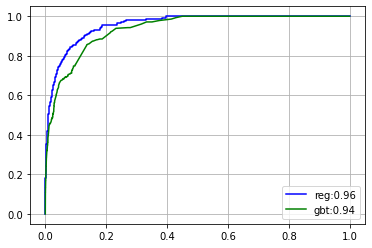

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr_reg, tpr_reg, color = 'blue', label = "reg:{:.2f}".format(auc_reg))
plt.plot(fpr_gbt, tpr_gbt, color = 'green', label = "gbt:{:.2f}".format(auc_gbt))
plt.legend()
plt.grid()
plt.show()

### Save predictions on test and train data for modelCalibration

In [21]:
# save test predictions to csv
df = pd.DataFrame(data={'label': y_test, 'predReg': test_scores_reg[:,1], 
                  'predGbt': test_scores_gbt[:,1] })
df.to_csv("./data/predictions.csv", index=False)

# save test predictions to csv
train_scores_reg = logreg.predict_proba(X_train)
train_scores_gbt = gbt.predict_proba(X_train)
df = pd.DataFrame(data={'label': y_train, 'predReg': train_scores_reg[:,1], 
                  'predGbt': train_scores_gbt[:,1] })
df.to_csv("./data/predictions_train.csv", index=False)